# QC report: HILICpos Rafi samples 
- Minghao Gong; 07/27/2022
- This notebook specifically fits Asari run

# Load libraries

In [1]:
# Let the middle rows included.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [2]:
#load libraries 
shhh <- suppressPackageStartupMessages # It's a library, so shhh!
shhh(library(FactoMineR))
shhh(library(factoextra))
shhh(library(reshape2))
shhh(library(tidyverse))
shhh(library(RColorBrewer))
shhh(library(gridExtra))
shhh(library(pheatmap))
library(repr)#jupyter notebook R ; image manipulation 
#shhh(library(devtools))
#install_github("vqv/ggbiplot")
shhh(library(ggbiplot))
options(warn=-1)#dont show warnings in Output 
options(digits = 14) # Or any higher number; fixing decimal places

library("rjson")

source('./utilis/utlis_MQC.R')

# Read tables

## load Metadata & feature table
- Here first use the peak Area table

# !!! What meta/feature/filtered tables in use?
- HILICpos

In [3]:
meta_path <- "../../input/sequence_file/clean_meta_df.csv"
featab_path <- "../../input/HILICpos_mzML/asari_project_output_727153535/preferred_Feature_table.tsv"
# filtered_featab_path <- "../../output/asari_prep_HILICpos_10//blankM_groupFil0.4_HILICpos_featab.csv"

#### Read metadata table

In [4]:
# metadata information
meta_df <- read_csv(meta_path)

Rows: 24 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): tID, Sample ID, tID_dedup, class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
head(meta_df)

tID,Sample ID,tID_dedup,class
<chr>,<chr>,<chr>,<chr>
nist_2,nist_2,nist_2,nist
nist_4,nist_4,nist_4,nist
nist_6,nist_6,nist_6,nist
q3June2014_1b,q3June2014_1b_2,q3June2014_1,q3June2014
q3June2014_1b,q3June2014_1b_4,q3June2014_1,q3June2014
q3June2014_1b,q3June2014_1b_6,q3June2014_1,q3June2014


#### Read in the feature table
- Of note, since it is using tibble, row.names are suppressed; `COMP ID` comes as the first columns

In [16]:
asari_df <- read_delim(featab_path,delim = '\t')

Rows: 9431 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): id_number
dbl (34): mz, rtime, rtime_left_base, rtime_right_base, parent_masstrack_id,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
asari2data_feat_df_regExpr <- function(asari_df,regExpr_sample_cols) {
    sample_col_index = grep(regExpr_sample_cols,colnames(asari_df))
    featab_df = asari_df[,c(1,sample_col_index)]
    return(featab_df)
}

asari2data_feat_df_index <- function(asari_df,end_index = 11) {
    featab_df = asari_df[,c(1,end_index:ncol(asari_df))]
    return(featab_df)
}

In [27]:
featab_df = asari2data_feat_df_index(asari_df,12)

In [28]:
dim(featab_df)

[1] 9431   25

In [29]:
head(featab_df) # examine the table

id_number,q3June2014_2a_2,G1_Naive_1_300_2,G1_Naive_2_300_2,G1_Naive_3_300_2,G2_R5pos_1_142_2,G2_R5pos_2_200_2,G2_R5pos_3_150_2,G3_R5neg_1a_655_2,G3_R5neg_1b_655_2,G3_R5neg_2a_687_2,G3_R5neg_2b_687_2,G3_R5neg_3a_865_2,G3_R5neg_3b_865_2,nist_2,nist_4,nist_6,q3June2014_1b_2,q3June2014_1b_4,q3June2014_1b_6,q3June2014_2a_4,q3June2014_2a_6,q3June2014_2b_2,q3June2014_2b_4,q3June2014_2b_6
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,82606,27701,94249,89481,0,43734,22457,106522,117992,132798,117319,132436,103354,68263,101396,64873,93459,62270,86003,105882,68765,76538,160572,70725
F4,2632356,18042890,23587830,23522578,12798823,15422758,17903307,37784533,38169479,31623646,31050101,43125736,40203363,3190800,3377094,2753837,2356543,2954096,3629525,2852568,2322411,2764957,2776460,2503286
F5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,699388,875997,1293132,670703,635428,700917,770668,847395
F6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70986,51664,217983,229394,185677,347305,191157
F9,0,495727,0,376749,0,350334,0,0,0,0,0,338732,0,704164,654014,0,0,482596,502803,507673,0,427380,0,447753
F18,804717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,519009,475791,195636,697137,0,0,0,0


#### procedure for preoprocessing of data
- log2-transformation (currently the missing data is denoted by NA)
- Analysis the TIC
- Correlation heatmap

In [30]:
log2transform <- function(featab_df) {
    featab_df[featab_df == 0] = NA
    featab_df.log <- cbind(featab_df[,1],log2(featab_df[, 2:ncol(featab_df)])) # no need to add +1
    # featab_df.log[is.na(featab_df.log)] = 0
    return(featab_df.log)
}

In [31]:
# separate the annotation and feature values part and do log2 conversion
featab_df.log <- log2transform(featab_df) # no need to add +1
head(featab_df.log)

,id_number,q3June2014_2a_2,G1_Naive_1_300_2,G1_Naive_2_300_2,G1_Naive_3_300_2,G2_R5pos_1_142_2,G2_R5pos_2_200_2,G2_R5pos_3_150_2,G3_R5neg_1a_655_2,G3_R5neg_1b_655_2,G3_R5neg_2a_687_2,G3_R5neg_2b_687_2,G3_R5neg_3a_865_2,G3_R5neg_3b_865_2,nist_2,nist_4,nist_6,q3June2014_1b_2,q3June2014_1b_4,q3June2014_1b_6,q3June2014_2a_4,q3June2014_2a_6,q3June2014_2b_2,q3June2014_2b_4,q3June2014_2b_6
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,F1,16.333958953638,14.757650437737,16.524189690740,16.449293758957,NA,15.416467685806,14.454877592497,16.700791895621,16.848329520875,17.018873893623,16.840077153498,17.014935816837,16.657234699373,16.058816198469,16.629641214609,15.985330536187,16.512045980172,15.926249658765,16.392099365058,16.692097825637,16.069386828568,16.223888582257,17.292860816962,16.109932651171
2,F4,21.327923181765,24.104927103400,24.491539365865,24.487542847855,23.60950780802,23.878557444843,24.093722762977,25.171292456047,25.185916158618,24.914500374820,24.888094625474,25.362045742775,25.260812851698,21.605486752354,21.687350906042,21.393011738001,21.168240575872,21.494285279812,21.791349322784,21.443829847457,21.147191879681,21.398825613484,21.404815180735,21.255391697430
3,F5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,19.415733517128,19.740566403518,20.302438119047,19.355314529562,19.277369137940,19.418884090174,19.555749962452,19.692675090634
4,F6,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,16.115246901038,15.656871725614,17.733856101310,17.807468131338,17.502435592667,18.405843655163,17.544398505791
5,F9,NA,18.919186312437,NA,18.523244156938,NA,18.418371483276,NA,NA,NA,NA,NA,18.369784759056,NA,19.425551946527,19.318961993210,NA,NA,18.880456432253,18.939633732135,18.953540008481,NA,18.705159870558,NA,18.772343572914
6,F18,19.618121985018,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,18.985400030636,18.859968456628,17.577812346990,19.411082674000,NA,NA,NA,NA


### Overall Density Distribution of data 
  

- first two columns are gona be mz and rt and rest should be the samples ; nothing else 

- two parameters needed : 
  - data : - Data can be log2(prefferably) /linear; if have nas will be imputed to calulate density
  
  - y_lim_param; to adjust height of y axis(desnity) in the plot; later to automate it may be 
  

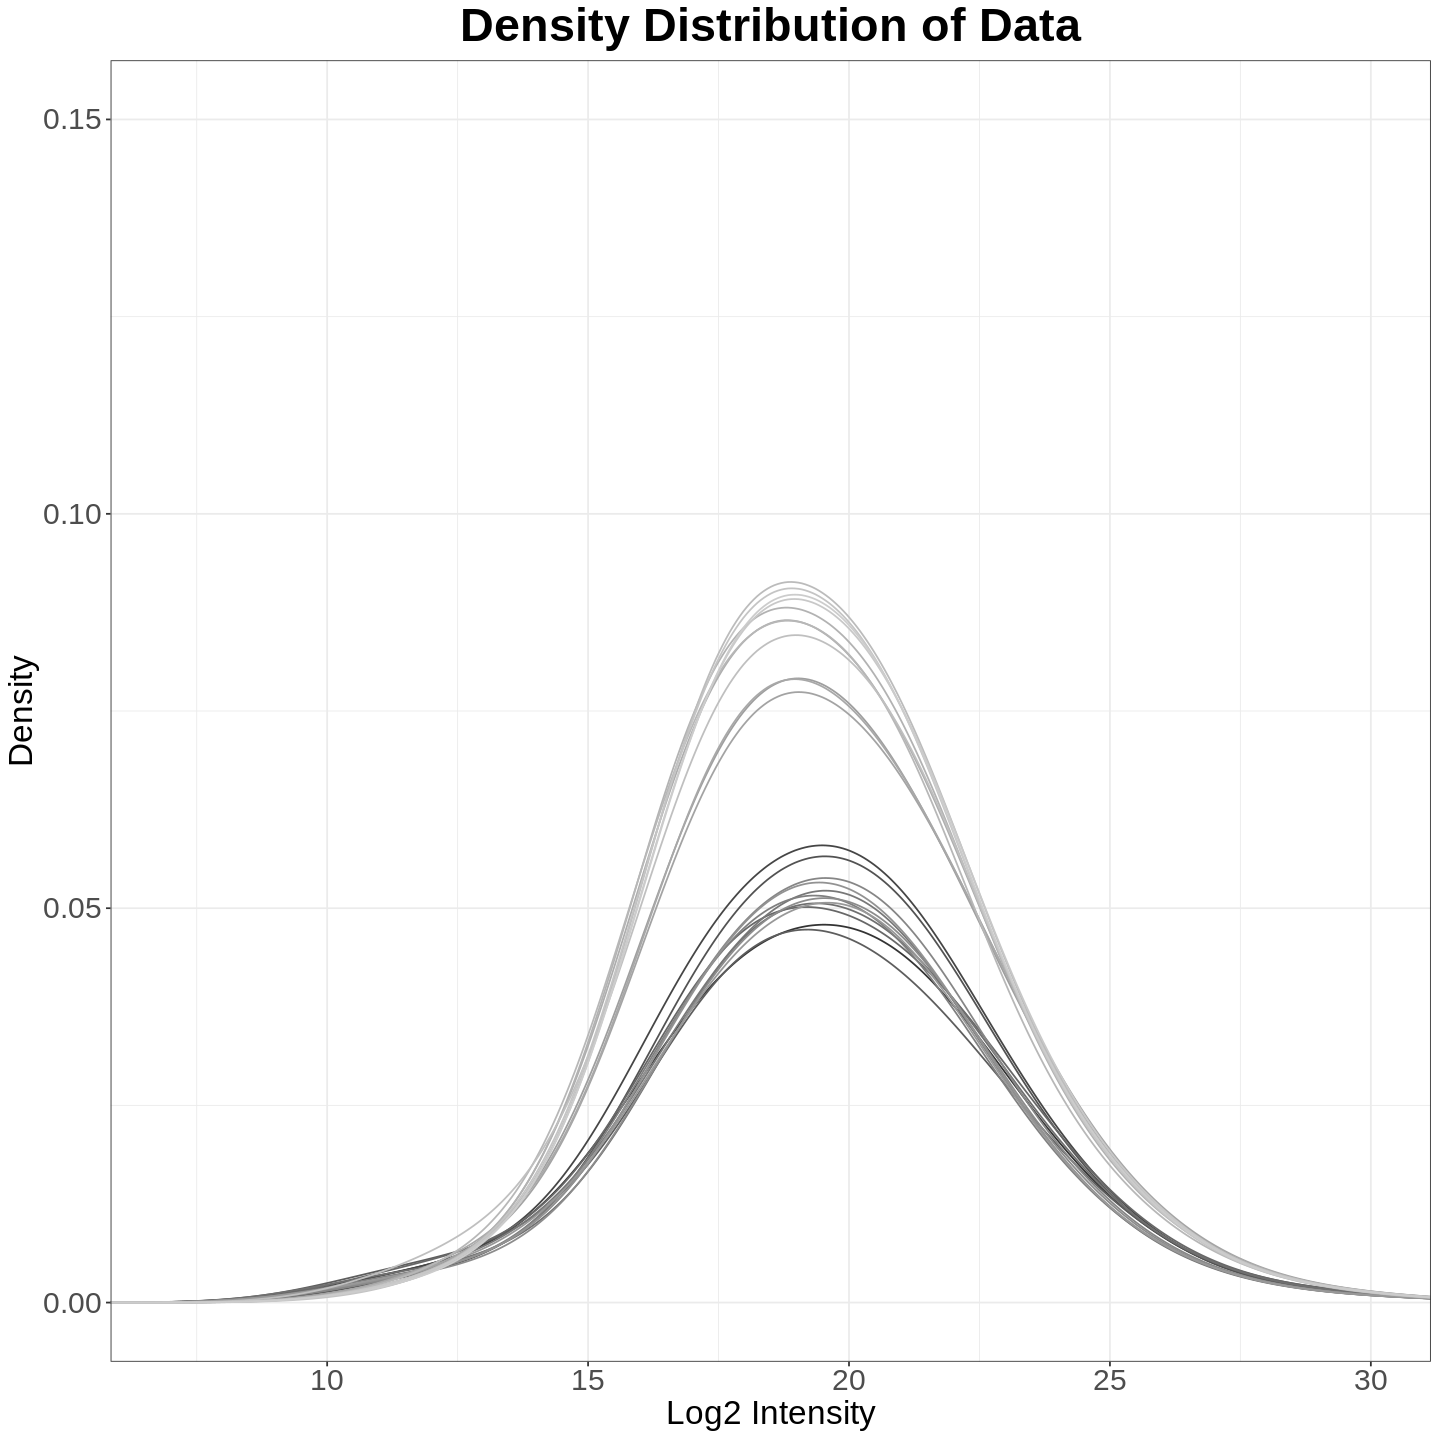

In [32]:
options(repr.plot.width=12, repr.plot.height=12, res=200)
suppressMessages(custom_density_plot(featab_df.log[,2:ncol(featab_df.log)], 
                                     y_lim_param=0.15))

### Mean TIC ACross Samples 

Input:

- data ; if nas ; willl be imputed for 0s within the function because we need to take into account the missing values in each sample to properly detect low intensity samples 
- optional ; metadata ; if present will factor color it ; if not then will not 


Note ; if x-axis need be changed for fontsize ; use   axis.title.x = element_text( size=16) in plotMeanTic function to control;

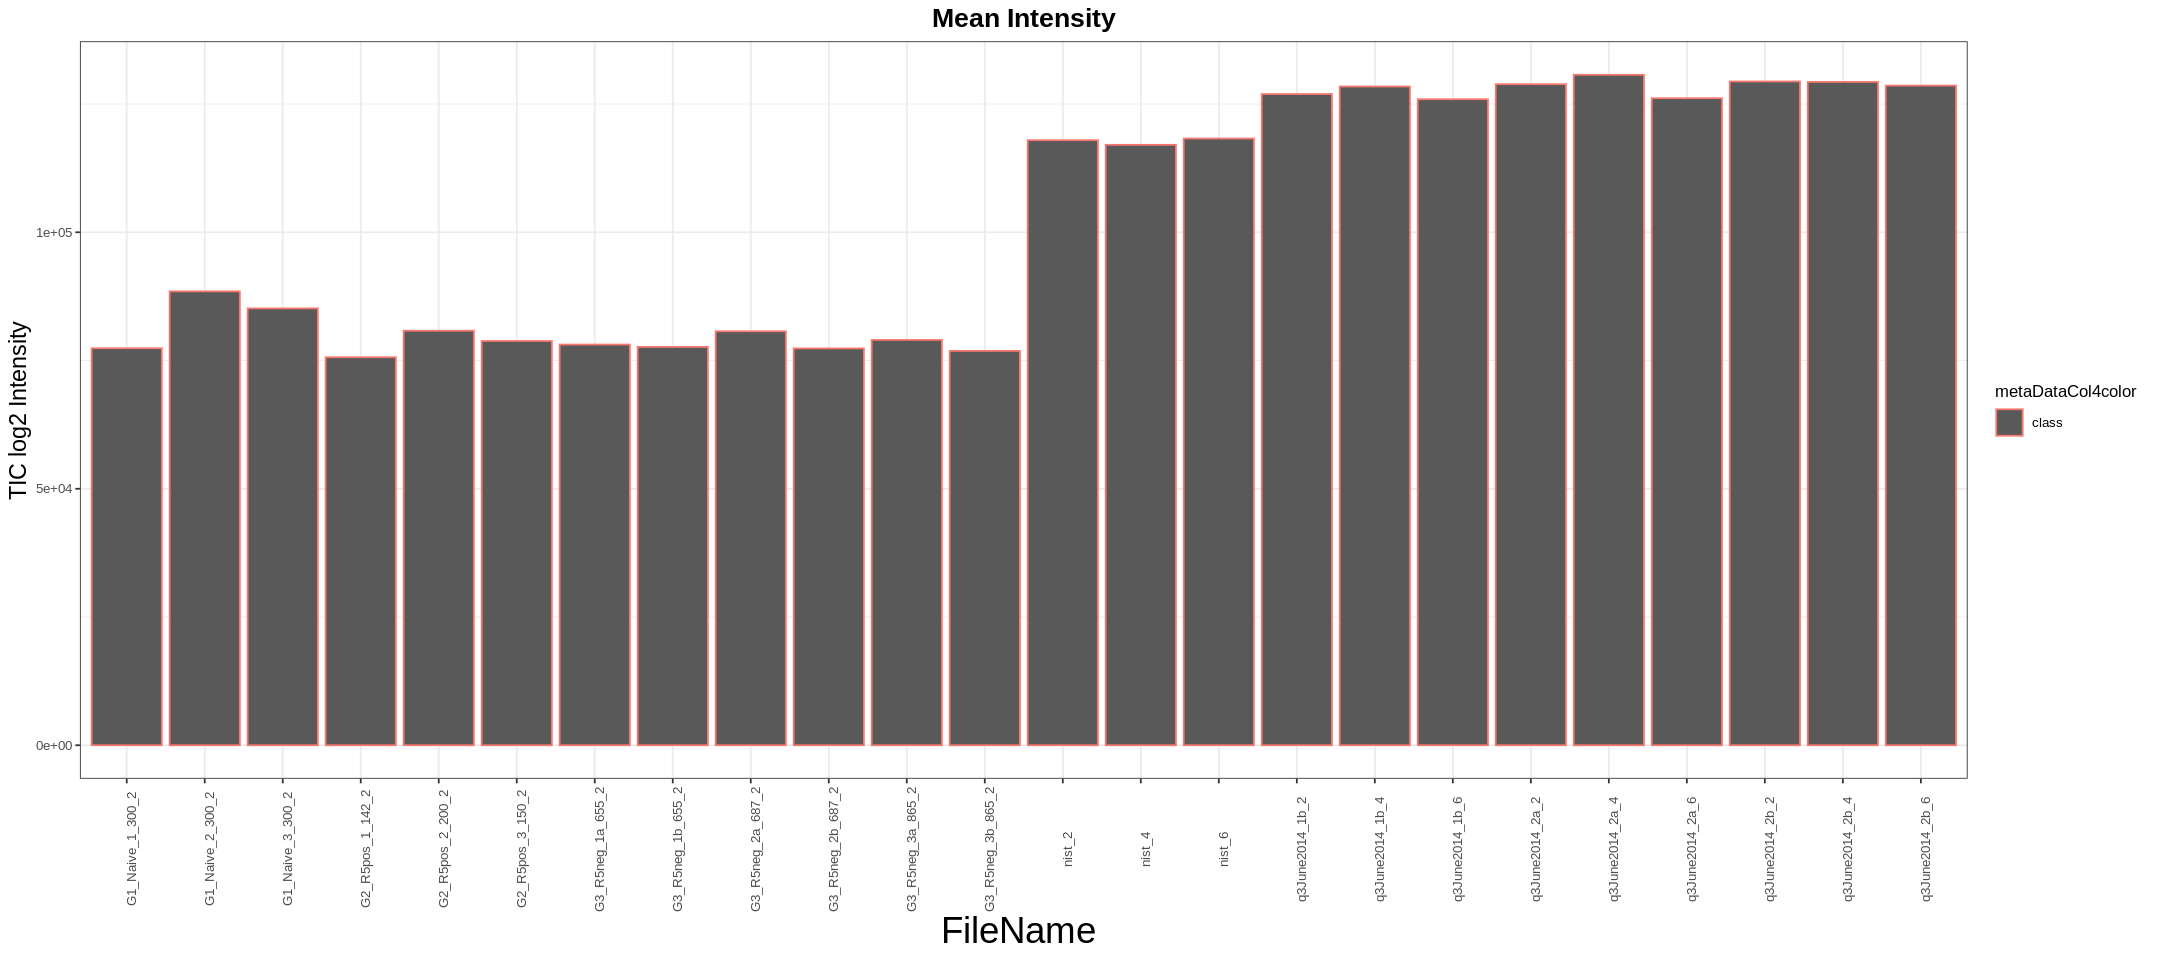

In [49]:
options(repr.plot.width=18, repr.plot.height=8, res=200)
suppressMessages(plotTIC(featab_df.log,meta_df,"Sample ID","class"))
#control xaxis font size;axis.title.x = element_text( size=16)

## Decide SD cutoff for outliers by yourself if need be

In [50]:
get_TIC_outliers(featab_df.log,2)

columnsum,Sample.ID
<dbl>,<chr>


### Missing values plot 

Input:

- logged 2/linear scale  data with nas ; no imputation happening in the function as i am counting Nas 


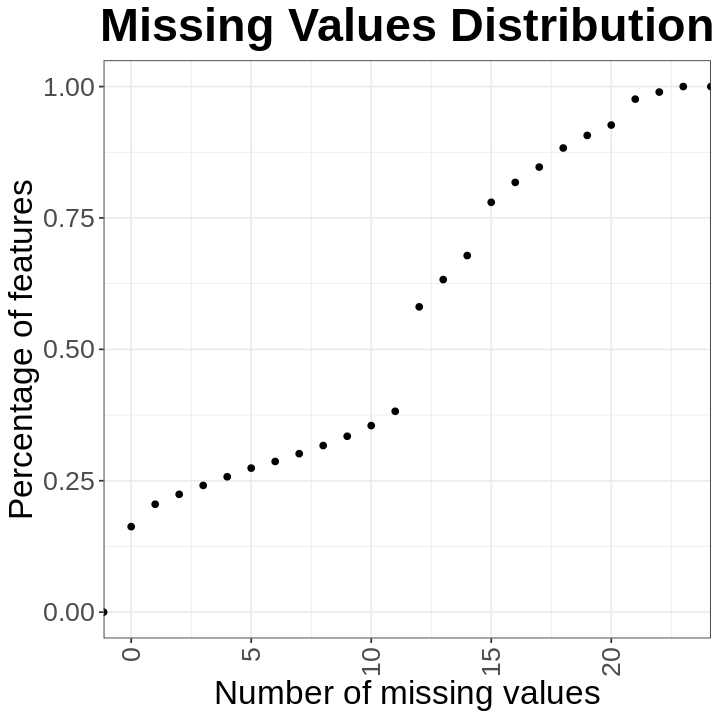

In [35]:
source('./utilis/utlis_MQC.R')
options(repr.plot.width=6, repr.plot.height=6, res=200)
plot_NA_cdf(featab_df.log, present_percentage = FALSE)

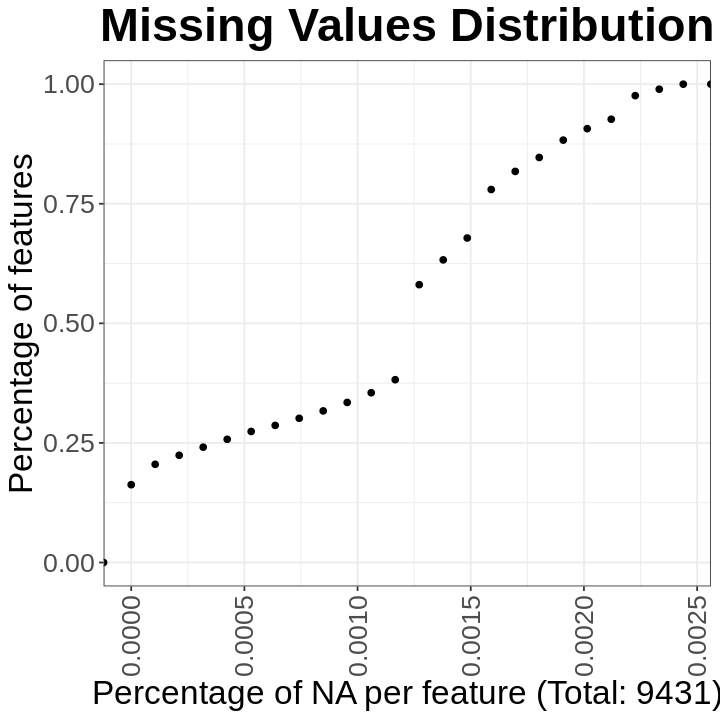

In [36]:
options(repr.plot.width=6, repr.plot.height=6, res=200)
plot_NA_cdf(featab_df.log, present_percentage = TRUE)

### Corelation bw samples 

In [37]:
# A function that help later step as correlation plot cannot handle very well with zero values
mssingValueAsNA <- TRUE # NA is good to skip this step
if (!mssingValueAsNA) {
    featab_df.log.NA <- featab_df.log
    featab_df.log.NA[featab_df.log == 0] <- NA  # Turn 0 into NA
    featab_df.log <- featab_df.log.NA
}

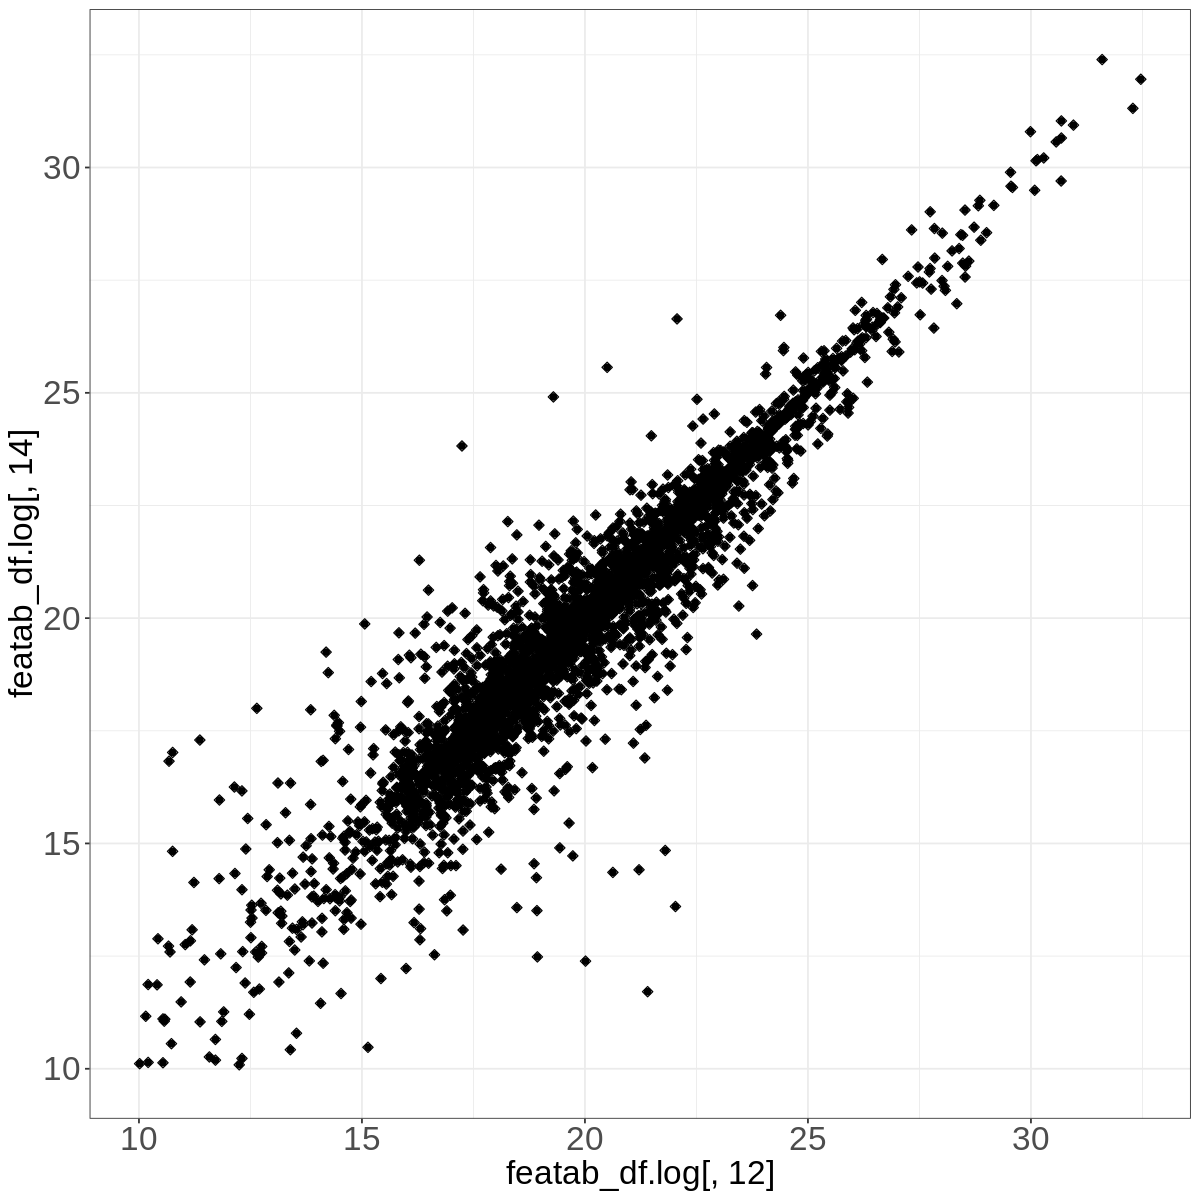

In [38]:
#options(repr.plot.width=16, repr.plot.height=20, res=200)
# reproducibility of injection replicates
#figure options ; change to the needs
options(repr.plot.width=10, repr.plot.height=10)
  ggplot(featab_df.log, aes(x=featab_df.log[,12], y=featab_df.log[,14])) + geom_point()+
  geom_point(size=2, shape=23) +# Change the point size, and shape
  theme_bw()+#axis settings 
    theme(axis.text=element_text(size=20))+
 #axis labels settings 
    theme(axis.title=element_text(size=20))

## Heatmap 

Input: 
- data; log2/linear scale data with nas 
- metadata is optional 
- metadata include what to colors.

WishList Note:  fix if metadata is not passed; debug

In [53]:
colnames(meta_df)

[1] "File Name"     "Sample Type_x" "Sample.ID"     "mode"         
[5] "Name"          "Group"         "Visit Number"  "Sample Type_y"

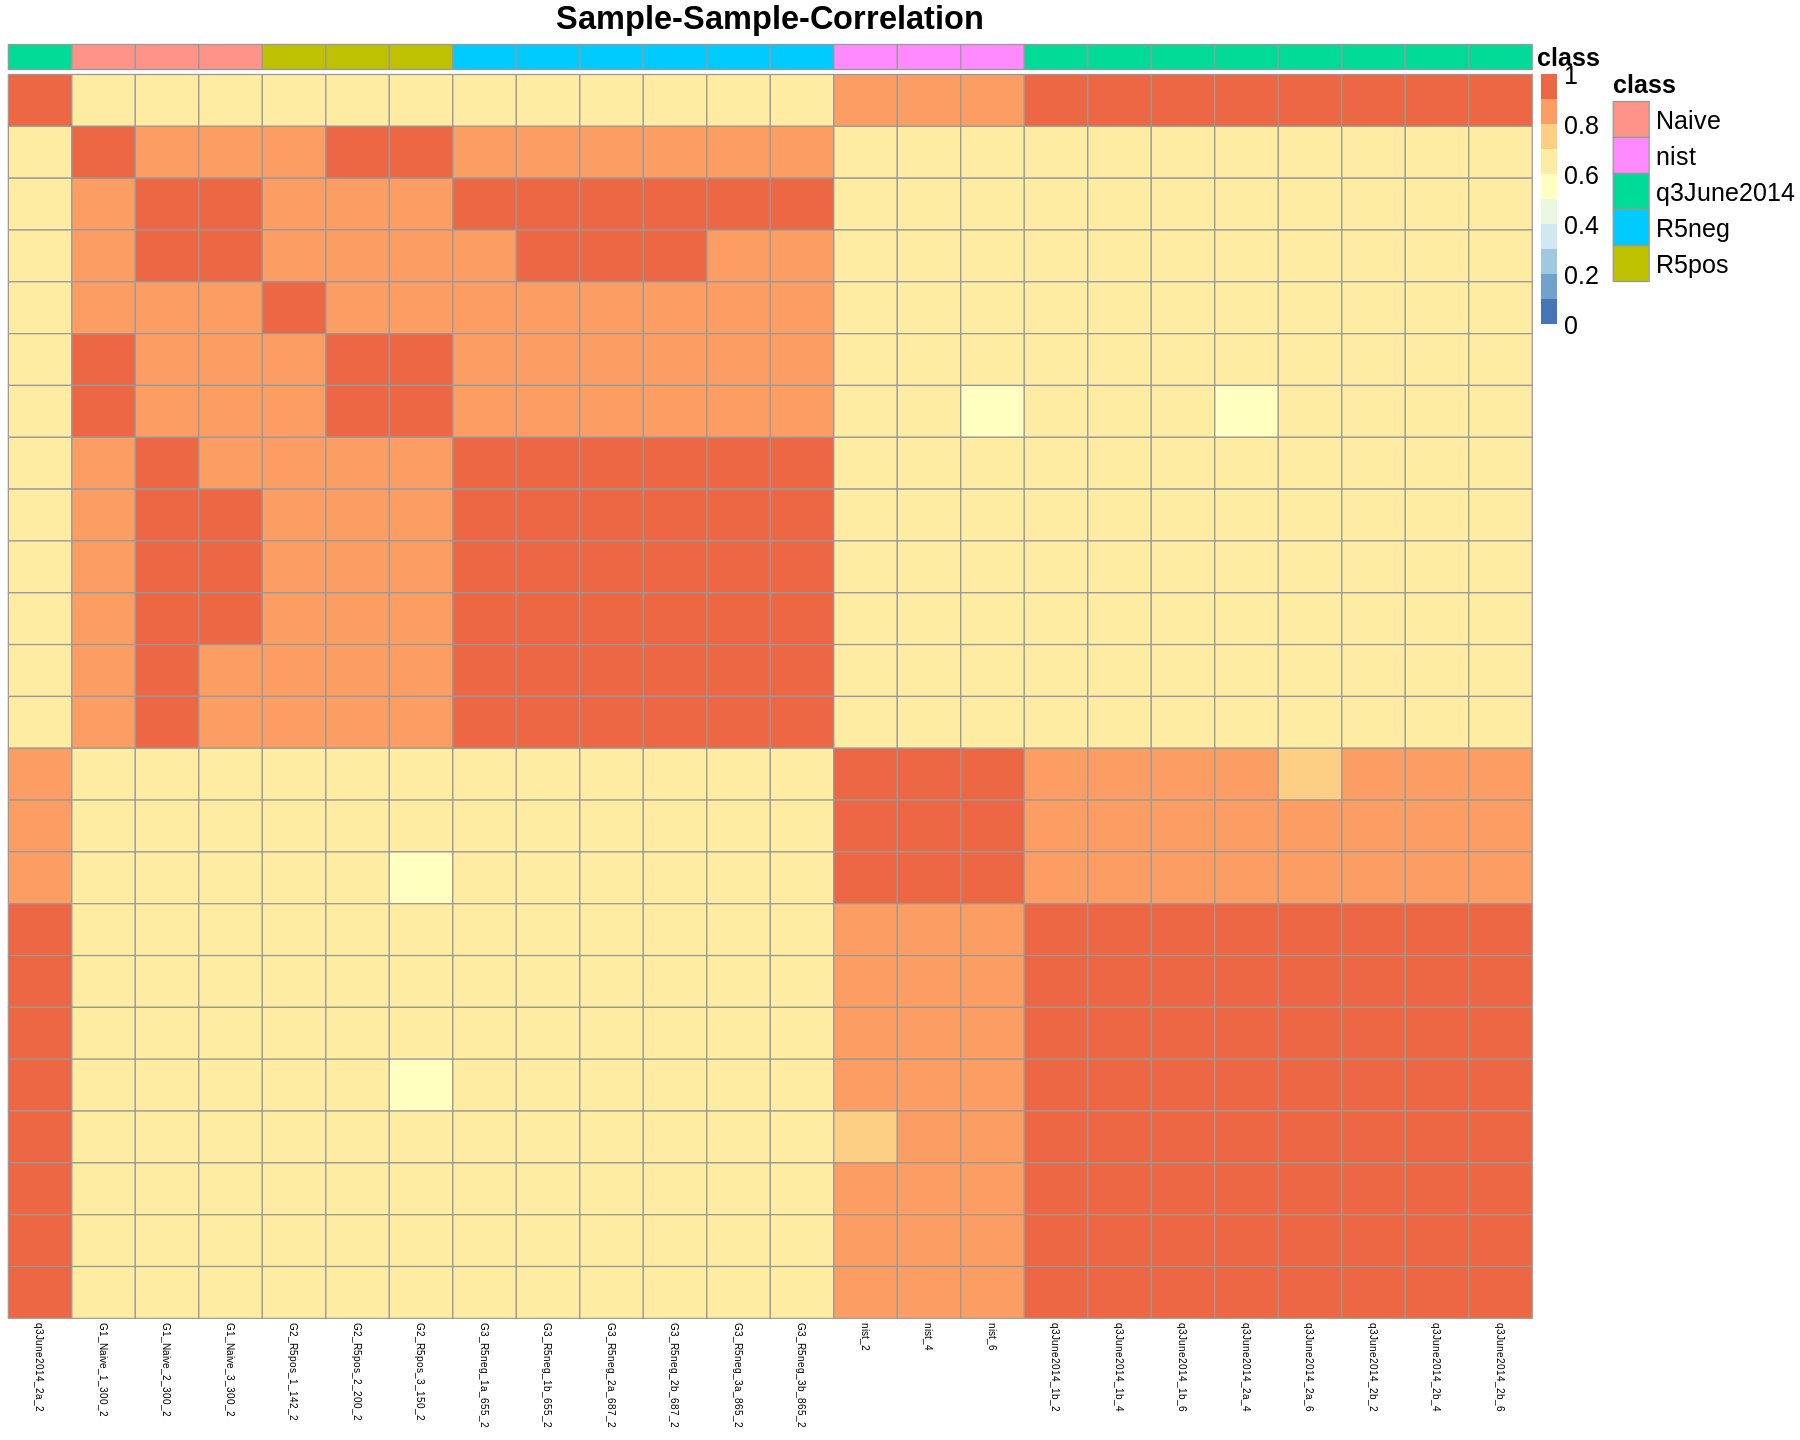

In [51]:
options(repr.plot.width=15, repr.plot.height=12, res=300)
suppressMessages(plot_heatmap(featab_df.log, meta_df, "Sample ID","class"))

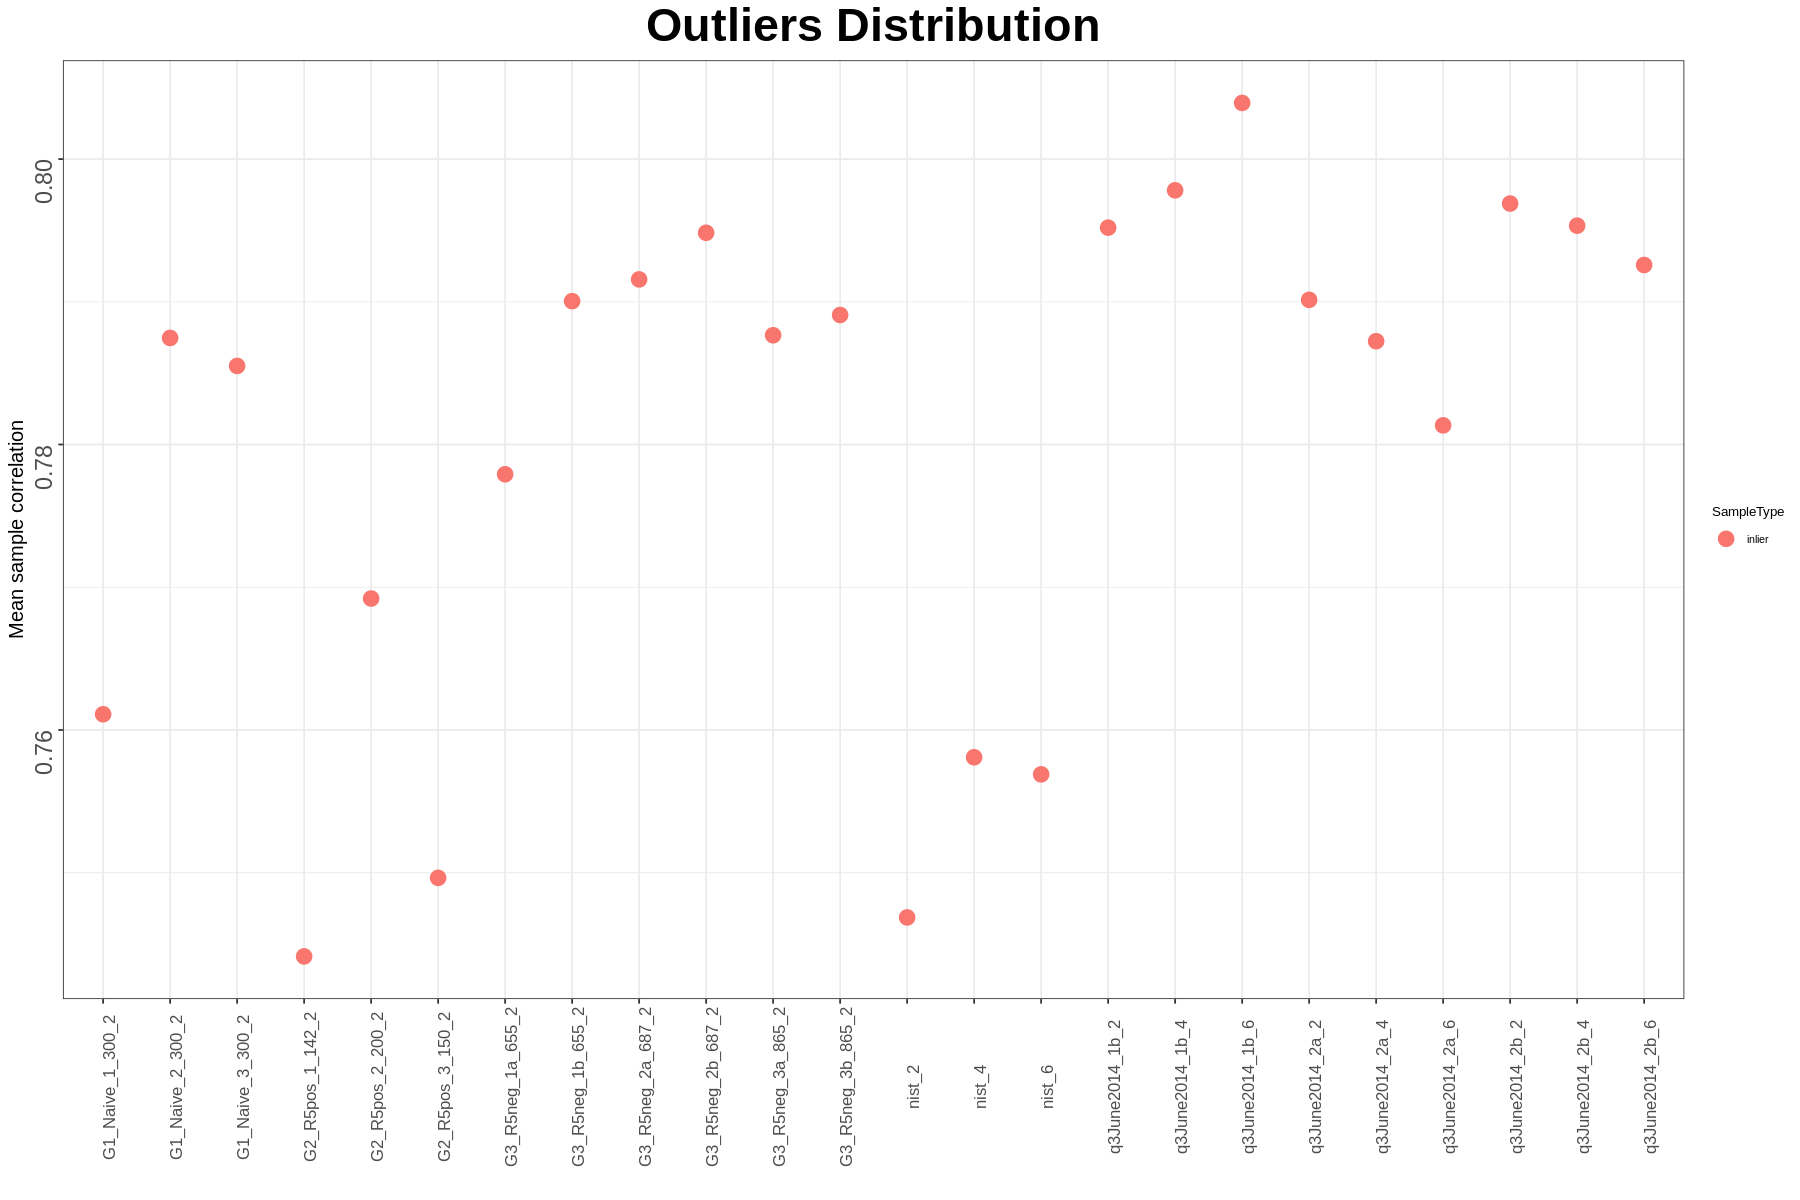

In [52]:
df.outliers <-  get_outliers_heatmap(featab_df.log)
options(repr.plot.width=15, repr.plot.height=10, res=300)
getoutliersplot(df.outliers)

In [53]:
filtered.df.outliers<-df.outliers %>% filter(SampleType=="outlier")
filtered.df.outliers

samples,columnmeancor,SampleType
<chr>,<dbl>,<chr>


# PCA

## Here if I use the unfiltered data

Joining, by = "Sample ID"
Too few points to calculate an ellipse

Too few points to calculate an ellipse

Too few points to calculate an ellipse



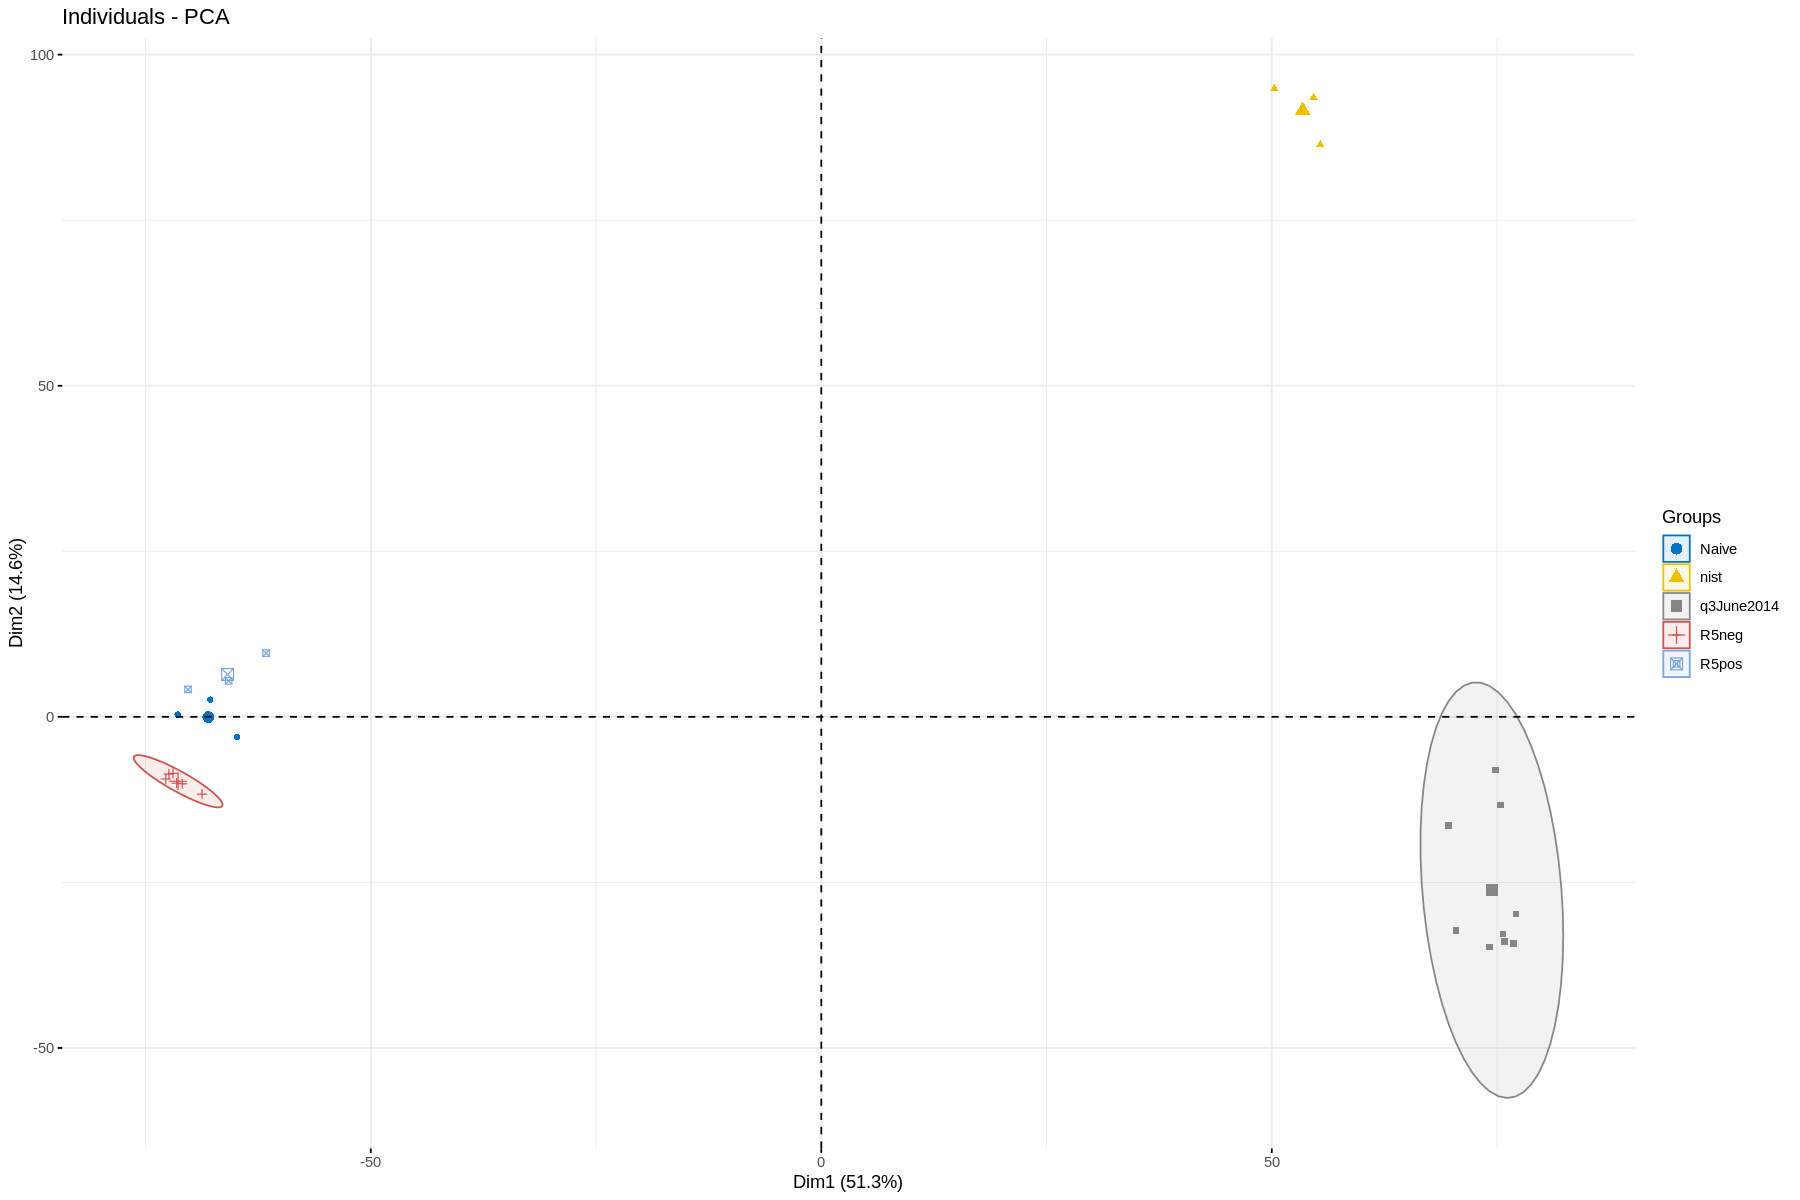

In [55]:
plotPCA(featab_df.log, meta_df, "Sample ID", "class", TRUE)

## Here I will use the filtered

In [61]:
# filt_df <- read_csv(filtered_featab_path)

# filt_df = asari2data_feat_df(filt_df,'HEU\\_[0-9]+|HUU\\_[0-9]+')
# filt_df.log2 = log2transform(filt_df)

# ----

# colnames(meta_df)

# plotPCA(filt_df.log2, meta_df, "Sample.ID", "Group", TRUE)

------------

-----